# IA353 - Redes Neurais
# EFC2 - Questão 5

## Autoencoder training and manifold visualization
## Partially based on https://www.kaggle.com/apapiu/manifold-learning-and-autoencoders

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Matheus dos Santos Rodrigues  

### 5.1. Imports

In [ ]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D,Convolution2DTranspose, MaxPooling2D, Flatten, Input
# from keras.optimizers import adam
from keras.utils.np_utils import to_categorical

### 5.2. Reading the data

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_images = x_train.reshape(x_train.shape[0], 28, 28)

In [ ]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

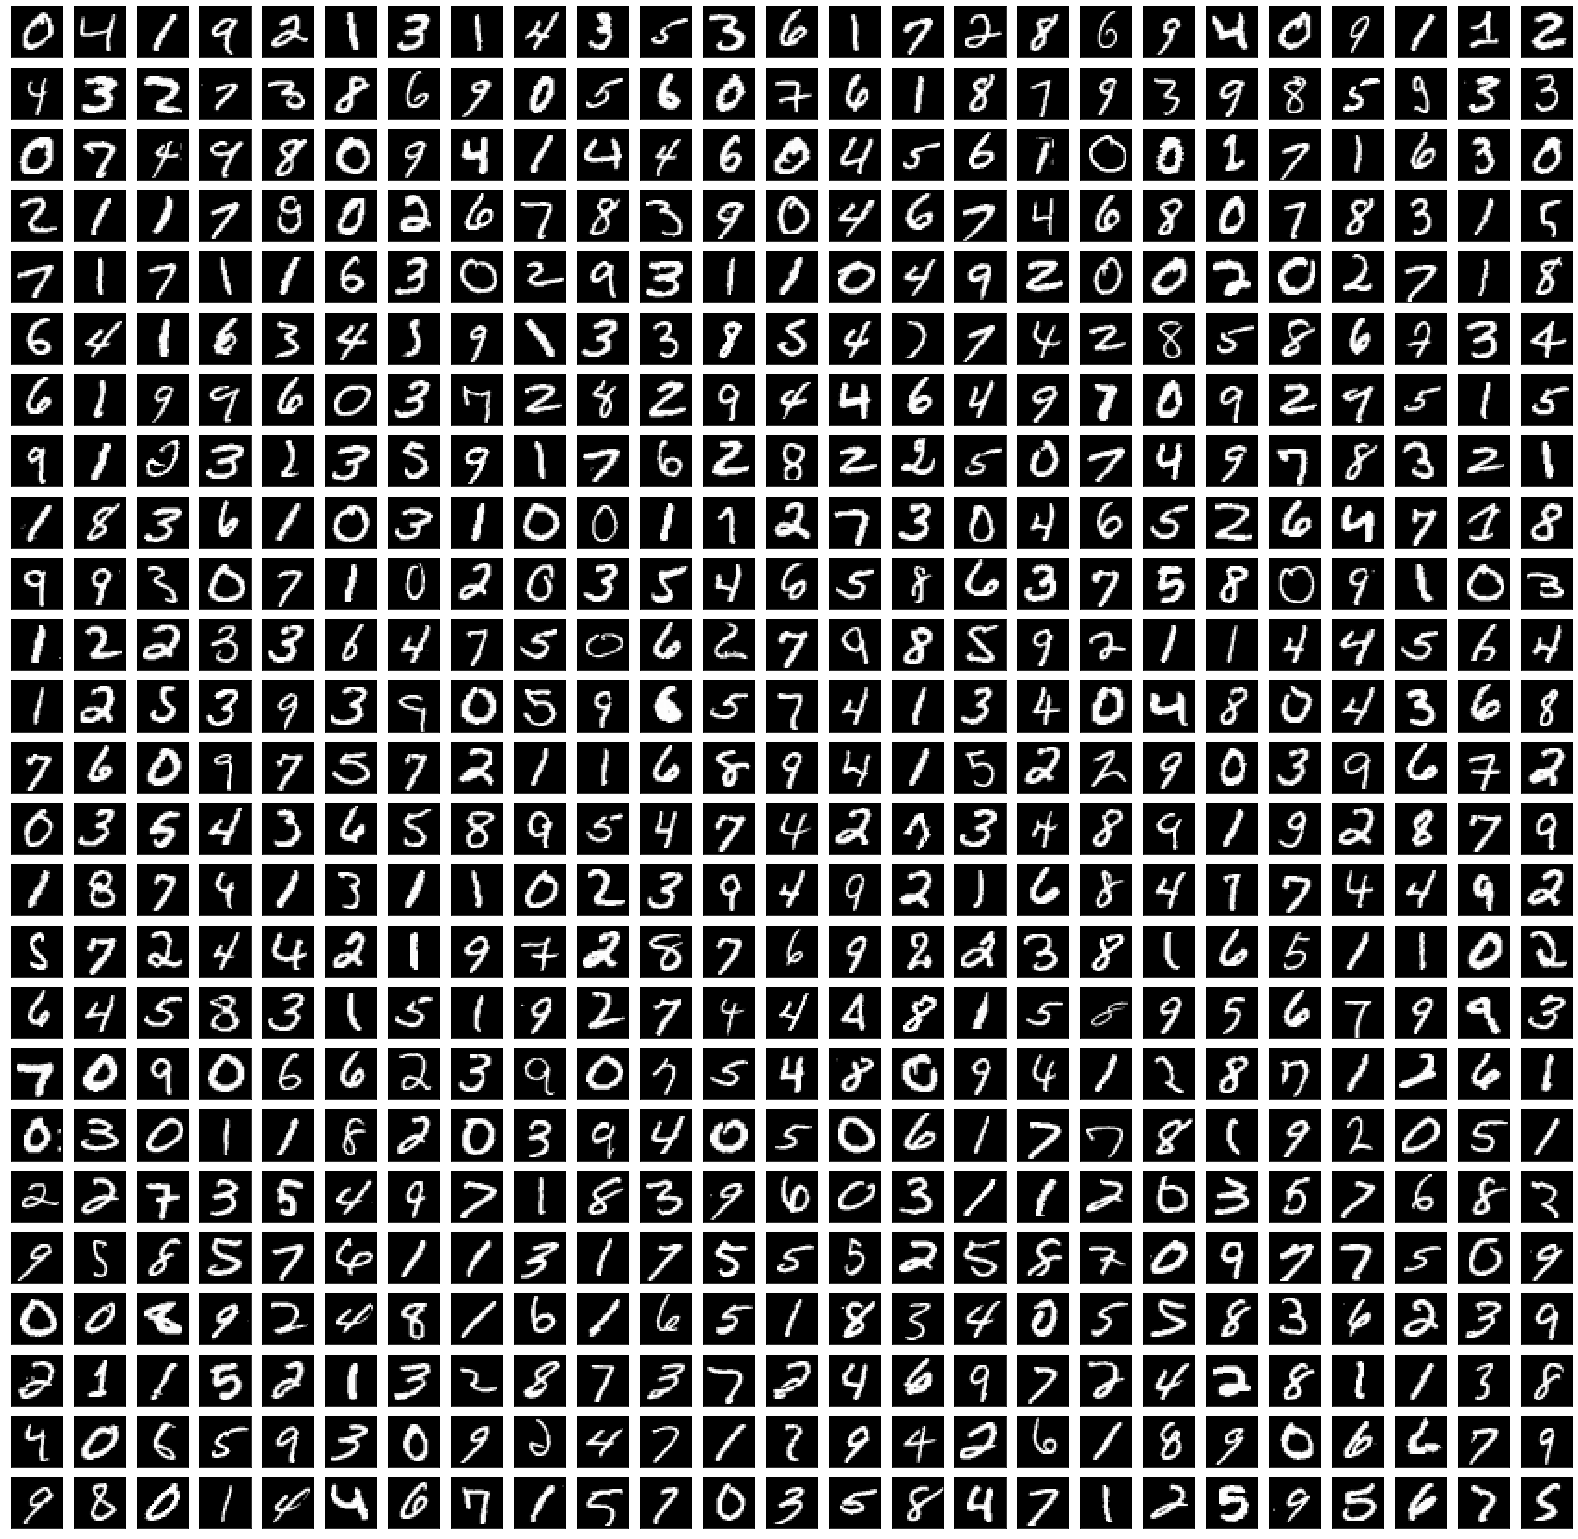

In [ ]:
# Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### 5.3 Proposal for the autoencoder architecture

*O modelo poposto é baseado em um autoencoder convolucional (CAE). Essencialmente, a rede é constituida por 3 camadas convolucionais seguida de uma camada Densa de 2 neurônios com função de ativação linear, que compreende o "código" gerado pelo codificador. As camadas seguintes consistem no decodificador. Foi utilizado Dropout de 0.5 para a camada FC (logo após o bottleneck) para proporcionar uma regularização do decodificador, e forçar o codificador a gerar um codigo competente.*

In [ ]:
input_img = Input(shape=(784,))

encoded = layers.Reshape((28,28,1))(input_img)

encoded = Convolution2D(filters=32, kernel_size=(15, 15), strides=1, activation='relu')(encoded)
encoded = Convolution2D(filters=64, kernel_size=(8, 8), strides=1, activation='relu')(encoded)
encoded = Convolution2D(filters=128, kernel_size=(5, 5), strides=1, activation='relu')(encoded)

encoded = layers.Flatten() (encoded)
encoded = Dense(2)(encoded) # Linear activation function at the bottleneck
decoded = Dense(1152, activation='relu')(encoded)
decoded = layers.Dropout(0.50)(decoded)

decoded = layers.Reshape((3,3,128))(decoded)
decoded = layers.Conv2DTranspose(filters=64, kernel_size=(7, 7), strides=4, activation='relu')(decoded)
decoded = layers.Conv2DTranspose(filters=32, kernel_size=(14, 14), strides=1, activation='relu')(decoded)
decoded = layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), strides=1, activation='relu')(decoded)
decoded = layers.Reshape((784,))(decoded)

autoencoder = Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        7232      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          131136    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 128)         204928    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2306

In [ ]:
autoencoder.compile(optimizer = "adam", loss = "msle")
# X = x_train.reshape(x_train.shape[0], 28, 28, 1)
X = x_train.reshape(x_train.shape[0], 784)
history = autoencoder.fit(X, X, batch_size = 128, epochs = 15, verbose = 1)

Epoch 1/15
469/469 [==============================] - 18s 37ms/step - loss: 0.0316
Epoch 2/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0221
Epoch 3/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0209
Epoch 4/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0202
Epoch 5/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0197
Epoch 6/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0194
Epoch 7/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0191
Epoch 8/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0190
Epoch 9/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0188
Epoch 10/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0186
Epoch 11/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0184
Epoch 12/15
469/469 [==============================] - 17s 36ms/step - loss: 0.0184
E

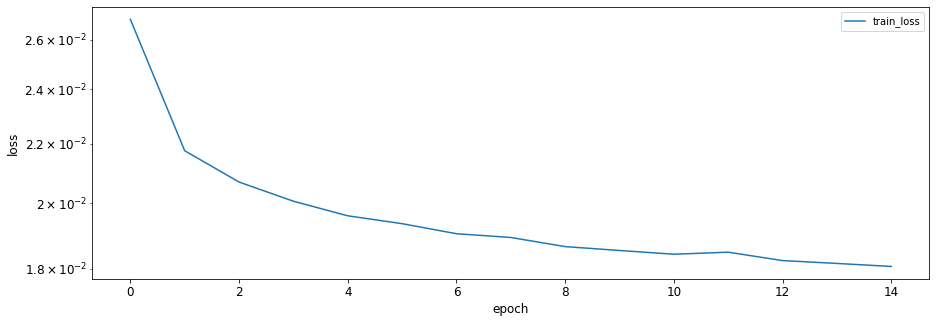

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

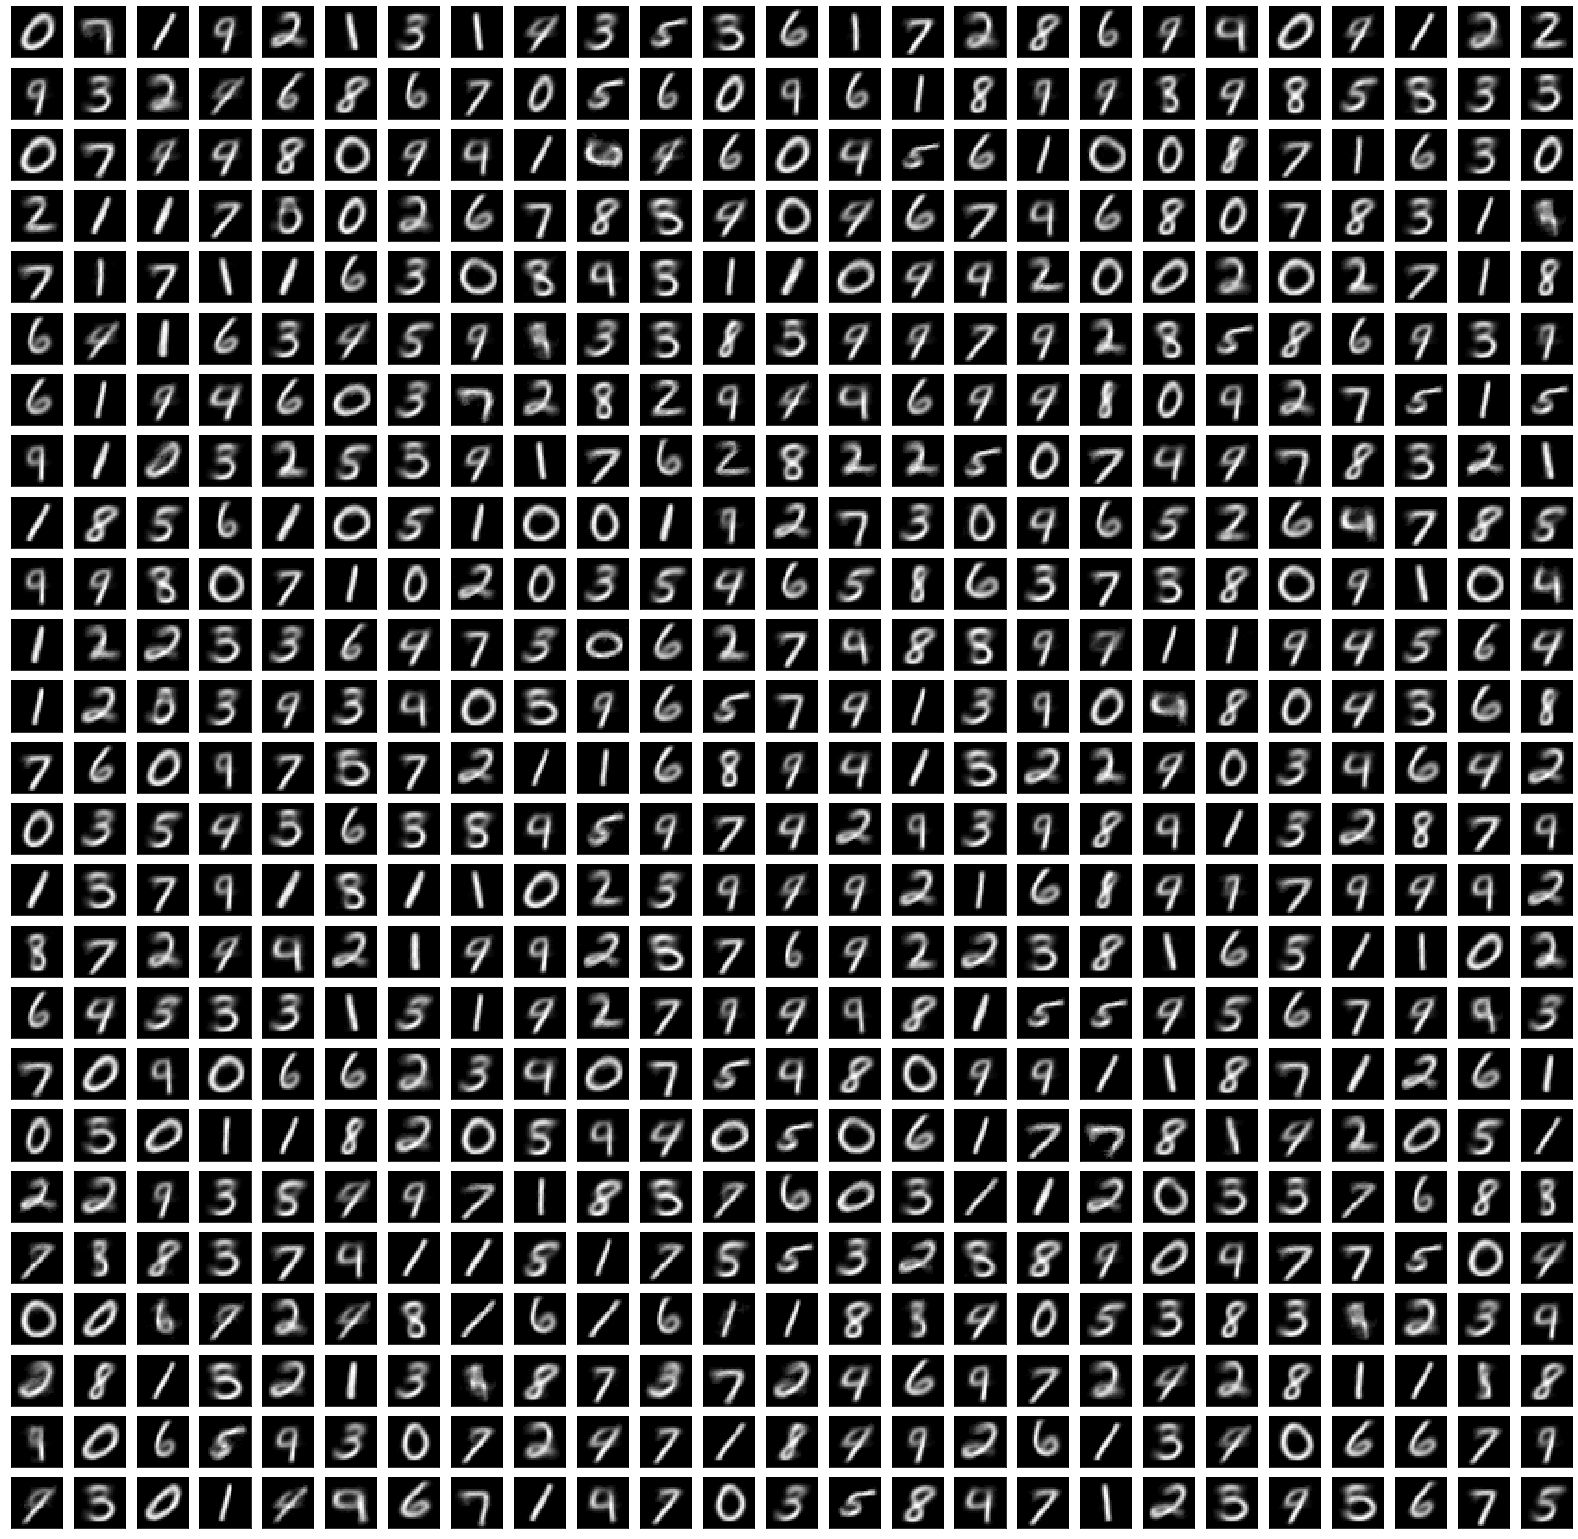

In [ ]:
# Visualization of 25 x 25 reconstructed images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(autoencoder.predict(np.expand_dims(x_images[ind].flatten(), 0)).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [ ]:
encoder = Model(input_img,encoded)

# Building the decoder
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-7]
encoded_layer_2 = autoencoder.layers[-6]
encoded_layer_3 = autoencoder.layers[-5]
encoded_layer_4 = autoencoder.layers[-4]
encoded_layer_5 = autoencoder.layers[-3]
encoded_layer_6 = autoencoder.layers[-2]
encoded_layer_7 = autoencoder.layers[-1]

decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = encoded_layer_3(decoder)
decoder = encoded_layer_4(decoder)
decoder = encoded_layer_5(decoder)
decoder = encoded_layer_6(decoder)
decoder = encoded_layer_7(decoder)

decoder = Model(encoded_input, decoder)

### 5.4 Visualizing the mapping of the labeled images in the manifold

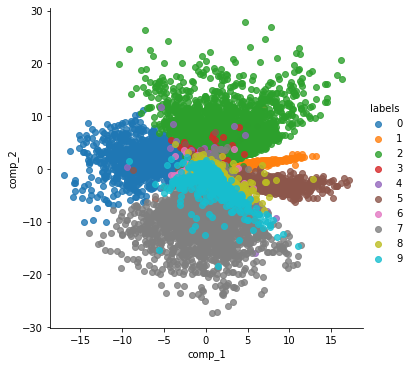

In [ ]:
import seaborn as sns

x_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

x_proj = encoder.predict(x_flat[:60000])
x_proj.shape

proj = pd.DataFrame(x_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:60000]
sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)

### 5.5. Generating new digits by moving along the manifold (latent 2D space)
**Please, adjust the scale whenever necessary.**

### 5.5.1 Moving along a circle

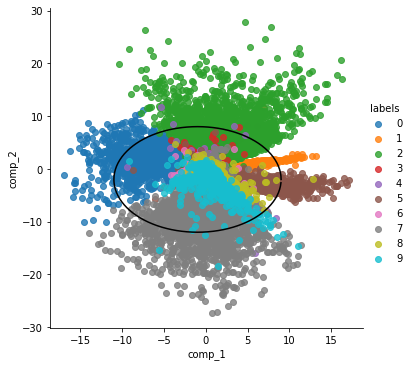

In [ ]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [10 * np.cos(2 * np.pi / 100 * i) - 1 for i in range(100)]
all_y = [10 * np.sin(2 * np.pi / 100 * i) - 2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

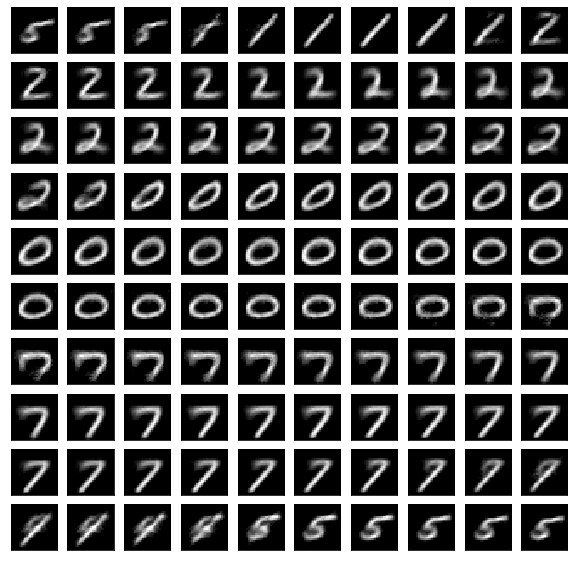

In [ ]:
# moving along a circle:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 10 * np.cos(2 * np.pi / 100 * i) - 1
    y = 10 * np.sin(2 * np.pi / 100 * i) - 2
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.2 Moving along an ellipse

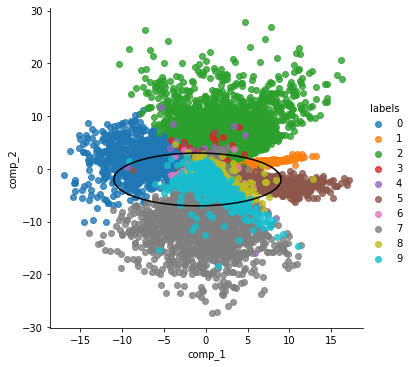

In [ ]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [10 * np.cos(2 * np.pi / 100 * i) - 1 for i in range(100)]
all_y = [5 * np.sin(2 * np.pi / 100 * i) - 2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

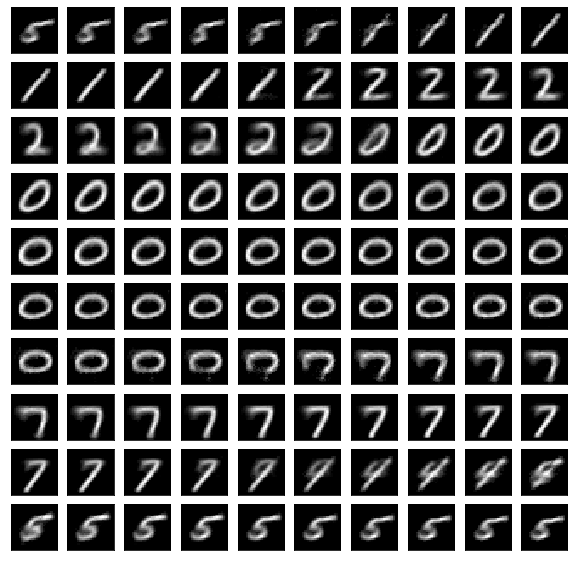

In [ ]:
# moving along a elipse:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 10 * np.cos(2 * np.pi / 100 * i) - 1
    y = 5 * np.sin(2 * np.pi / 100 * i) - 2
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.3 Moving along a grid

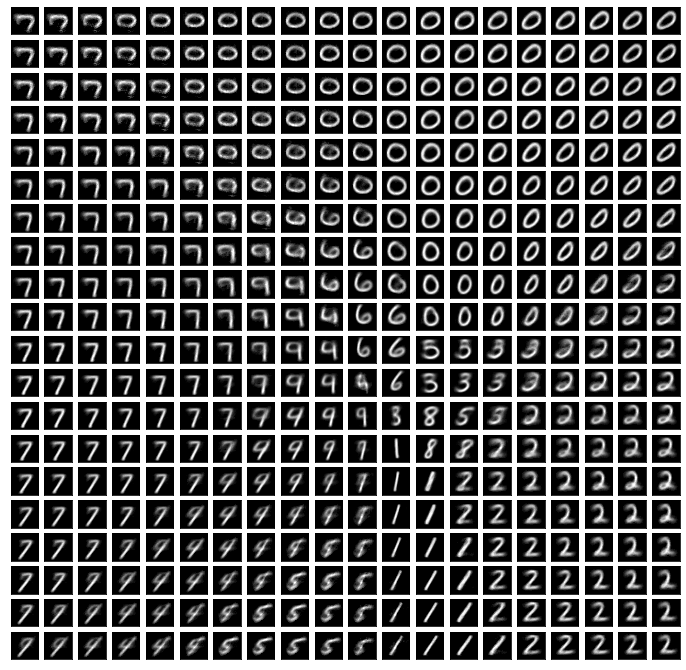

In [ ]:
# moving along a elipse:
_ = plt.figure(figsize=(12, 12))

for i in range(20):
    for j in range(20):
        
        _ = plt.subplot(20, 20, i * 20 + j + 1)
        
        pt = np.array([[ -6 + 10 * i / 19, -6 + 10 * j / 19]])
        _ = show(decoder.predict(pt).reshape((28, 28)))
        _ = plt.xticks([])
        _ = plt.yticks([])